In [1]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [2]:
import warnings
warnings.simplefilter('ignore')

## Chain graph Neural Network Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../algorithm1.png)

In [27]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

# from algorithm.penalty import *


from abc import ABC
from joblib import Parallel, delayed
import copy



class OptVar(ABC):
    def __init__(self, vectors):
        self.vectors = vectors
        
    def get_node_vectors(self, node):
        node_vectors = []
        for vec in self.vectors:
            node_vectors.append(vec[node])
        return node_vectors
    
    def set_node_vectors(self, node, node_vectors):
        for i, node_vec in enumerate(node_vectors):
            self.vectors[i][node] = node_vec
            
    def diff(self, var2):
        diff_vec = []
        for i, sub_w in enumerate(self.vectors):
            diff_vec.append(sub_w - var2.vectors[i])
        return OptVar(diff_vec)
    
    def mult(self, num):
        for i, sub_vec in enumerate(self.vectors):
            self.vectors[i] = num * sub_vec
    

class PrimalVar(OptVar):
    def __init__(self, primal_vectors, T_matrix, D):
        super(PrimalVar, self).__init__(primal_vectors)
        self.T_matrix = T_matrix
        self.D = D
            
    def update(self, new_u):
        hat_w = []
        for i, sub_w in enumerate(self.vectors):
            hat_w.append(sub_w - np.dot(self.T_matrix, np.dot(self.D.T, new_u.vectors[i])))
        return OptVar(hat_w)
    
class DualVar(OptVar):
    def __init__(self, dual_vectors, Sigma, D):
        super(DualVar, self).__init__(dual_vectors)
        self.Sigma = Sigma
        self.D = D
            
    def update(self, tilde_w):
        for i, sub_vec in enumerate(self.vectors):
            self.vectors[i] = sub_vec + np.dot(self.Sigma, np.dot(self.D, tilde_w.vectors[i]))

            
def primal_update(hat_w_i, datapoints, i):
    optimizer = datapoints[i]['optimizer']
    res = optimizer.optimize(
        datapoints[i]['features'], 
        datapoints[i]['label'], 
        hat_w_i, 
        datapoints[i]['degree'],
    )
    return res, i
    

            
def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
#     m, n = datapoints[0]['features'].shape
    m = len(datapoints[0]['features'])
    n = np.sum(datapoints[0]['features'][0].shape)

    # define the penalty function
    if penalty_func_name == 'norm1':
#         penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
   
    elif penalty_func_name == 'sq_norm2':
        penalty_func = SquaredNorm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1
    model = datapoints[0]['optimizer'].model
    out1, in1 = model.linear1.in_features, model.linear1.out_features
    out2, in2 = model.linear2.in_features, model.linear2.out_features
    
    l1 = np.random.random(in1*out1)
    l2 = np.random.random(in2*out2)
    new_w = PrimalVar([
        np.array([l1 for i in range(N)]), 
        np.array([l2 for i in range(N)]),
    ], T_matrix, D)
    hat_w = np.copy(new_w)
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = DualVar([
        np.array([l1 for i in range(E)]),
        np.array([l2 for i in range(E)]),
    ], Sigma, D)
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
#         if iterk % 2 == 0:
#             alg1_score = get_algorithm1_error(datapoints, new_w, samplingset)
#             print ('iter:', iterk, alg1_score)
        prev_w = copy.deepcopy(new_w)

        # algorithm 1, line 2
        hat_w = new_w.update(new_u)
        
#         results = Parallel(n_jobs=10)(delayed(primal_update)(hat_w.get_node_vectors(i), datapoints, i)
#                                              for i in samplingset)  
        
#         for res, i in results:
#             new_w.set_node_vectors(i, res)

        for i in samplingset:
            res, i = primal_update(hat_w.get_node_vectors(i), datapoints, i)
            new_w.set_node_vectors(i, res)
 
        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6
#                 optimizer = datapoints[i]['optimizer']
#                 new_w.set_node_vectors(i, optimizer.optimize(
#                     datapoints[i]['features'], 
#                     datapoints[i]['label'], 
#                     hat_w.get_node_vectors(i), 
#                     datapoints[i]['degree'],
#                 ))
                pass
            else:
                new_w.vectors[0][i] = hat_w.vectors[0][i]
                new_w.vectors[1][i] = hat_w.vectors[1][i]

        # algorithm 1, line 9
        tilde_w = new_w.diff(prev_w)
        tilde_w.mult(2)
        new_u.update(tilde_w)
        
        # algorithm 1, line 10
        new_u.vectors[0] = penalty_func.update(new_u.vectors[0])
        new_u.vectors[1] = penalty_func.update(new_u.vectors[1])
        

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            alg1_score = get_algorithm1_error(datapoints, new_w, samplingset)
            iteration_scores.append(alg1_score)

    # print (np.max(abs(new_w - prev_w)))
    
    for i in range(N):
        optimizer = datapoints[i]['optimizer']
        
        optimizer.model.linear1.weight.data = torch.from_numpy(
            np.array(new_w.vectors[0][i].reshape(in1, out1), dtype=np.float32))
        optimizer.model.linear2.weight.data = torch.from_numpy(
            np.array(new_w.vectors[1][i].reshape(in2, out2), dtype=np.float32))


    return iteration_scores, new_w, new_u


### Primal Update 

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [8]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC
import torch.nn.functional as F

# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

# The SimpleLinear which is for MNIST experiment
class SimpleLinear(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28, h1)
        self.linear2 = torch.nn.Linear(h1, 2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        out1, in1 = self.model.linear1.in_features, self.model.linear1.out_features
        out2, in2 = self.model.linear2.in_features, self.model.linear2.out_features
        
        torch_old_weight0 = torch.from_numpy(np.array(old_weight[0], dtype=np.float32).reshape(in1, out1))
        torch_old_weight1 = torch.from_numpy(np.array(old_weight[1], dtype=np.float32).reshape(in2, out2))
        
        if np.sum(old_weight[0]) == 0:
#             print('hereee ', np.sum(old_weight[0]))
            self.model.linear1.weight.data = torch.tensor(np.array(np.random.rand(in1*out1), dtype=np.float32).reshape(in1, out1))
            self.model.linear2.weight.data = torch.tensor(np.array(np.random.rand(in2*out2), dtype=np.float32).reshape(in2, out2))
        else:
            self.model.linear1.weight.data = torch.tensor(np.array(old_weight[0], dtype=np.float32).reshape(in1, out1))
            self.model.linear2.weight.data = torch.tensor(np.array(old_weight[1], dtype=np.float32).reshape(in2, out2))
            
        for iterinner in range(40):
#         for iterinner in range(30):
            y_pred = self.model(x_data)
#             y_pred = torch.argmax(y_pred, axis=1)
#             loss1 = self.criterion(y_pred.ravel(), y_data.ravel())
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear1.weight.data - torch_old_weight0) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss3 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear2.weight.data - torch_old_weight1) ** 2)
            loss = loss1 + loss2 + loss3
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

#         print('old_weight', old_weight)
#         print('model', self.model.linear1.weight.data.numpy().ravel(), self.model.linear2.weight.data.numpy().ravel())
        return [self.model.linear1.weight.data.numpy().ravel(), 
                self.model.linear2.weight.data.numpy().ravel()]


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model, criterion):
#         criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


### Dual Update 

As mentioned in the paper, the dual update has a penalty function(line 10) which is either norm1, norm2, or mocha.

In [9]:
# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The squared norm2 penalty function
class SquaredNorm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(SquaredNorm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u
    
    

# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Create Chain Graph

Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes.

In [43]:
# from algorithm.optimizer import *
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from sklearn.manifold import TSNE


from scipy.spatial import cKDTree as KDTree

def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    """

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))



def get_images():
    transforms = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                     ])
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)

    dl = DataLoader(mnist_dataset)

    X = dl.dataset.data # (60000,28, 28)
    y = dl.dataset.targets #(60000)

    # normalize to have 0 ~ 1 range in each pixel

    X = X / 255.0
    
    cluster_nums = [[0, 1], [2, 3]]
    
    cluster_data0 = np.concatenate((np.where(y==cluster_nums[0][0])[0], np.where(y==cluster_nums[0][1])[0]))
    random.shuffle(cluster_data0)
    
    cluster_data1 = np.concatenate((np.where(y==cluster_nums[1][0])[0], np.where(y==cluster_nums[1][1])[0]))
    random.shuffle(cluster_data1)
    
    cluster_data = [
        cluster_data0,
        cluster_data1,
    ]
    
    all_cluster_data = np.concatenate((cluster_data0 , cluster_data1))
    selected_X = X[all_cluster_data].reshape(-1, 28*28)
    selected_embedded = TSNE(n_components=2, learning_rate='auto',
                            init='random').fit_transform(selected_X)
    
    all_embeded = np.zeros((len(X), 2))
    all_embeded[all_cluster_data] = selected_embedded
    return X, y, cluster_data, all_embeded


from scipy.spatial import cKDTree as KDTree

def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    """

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


def get_chain_data(cluster_sizes, eps, X, y, cluster_data, all_embeded, h1=200, num_neig=3):
    '''
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_nums = [[0, 1], [2, 3]]

    N = np.sum(cluster_sizes)
    E = N-1
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    feature_size = int(10000//cluster_sizes[0])
    train_size = int(feature_size*0.8)
    
    # create the data of each node needed for the algorithm 1 
    node_degrees = np.full(N, 1.0/num_neig)
#     np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    embeded_features = []
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = all_embeded[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            res = np.sort(res, axis=0)
            embeded_features.append(res)
            test_features = X[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            '''
            features: the feature vector of node i 
            '''
            label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][:train_size]
            test_label = y[cluster_data[i][j*feature_size:(j+1)*feature_size]][train_size:]
            
            label[label == cluster_nums[i][0]] = 0
            label[label == cluster_nums[i][1]] = 1
            
            test_label[test_label == cluster_nums[i][0]] = 0
            test_label[test_label == cluster_nums[i][1]] = 1
            '''
            label: the label of the node i
            '''
            
            true_labels.append(label)

            model = SimpleLinear(h1=h1) 
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = TorchLinearOptimizer(model, criterion)
#             optimizer = TorchLogisticOptimizer(model)
#             features = Variable(torch.from_numpy(features)).to(torch.float32)
#             label = Variable(torch.from_numpy(label)).to(torch.float32) 
      
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'test_features': test_features,
                'degree': node_degrees[cnt],
                'label': label,
                'test_label': test_label,
                'optimizer': optimizer
            }
            cnt += 1
            
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    E = N*num_neig
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    cnt = 0
    for i in range(N):
        dists = []
        for j in range(N):
            dists.append(KLdivergence(embeded_features[i], embeded_features[j]))
        node_dists = np.argsort(dists)
        for k in range(num_neig):
            neig = node_dists[k+1]
            B[cnt, i] = 1
            B[cnt, neig] = -1
            weight_vec[cnt] = np.exp(-dists[neig])
            cnt += 1

    weight_vec = (weight_vec - np.min(weight_vec)) / (np.max(weight_vec) - np.min(weight_vec))
    

    return B, weight_vec, np.array(true_labels), datapoints




### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [28]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_error(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    
    true_labels = []
    test_true_labels = []
    pred_labels = []
    test_pred_labels = []
    for i in range(len(datapoints)):
        features = datapoints[i]['features']
        label = datapoints[i]['label'].ravel().detach().numpy()
        true_labels.append(label)
        
        pred_label = datapoints[i]['optimizer'].model(features)
        pred_label = torch.argmax(pred_label, axis=1).ravel().detach().numpy() 
        pred_labels.append(pred_label)
        
        
        test_features = datapoints[i]['test_features']
        test_label = datapoints[i]['test_label'].ravel().detach().numpy()
        test_true_labels.append(test_label)
        
        test_pred_label = datapoints[i]['optimizer'].model(test_features)
        test_pred_label = torch.argmax(test_pred_label, axis=1).ravel().detach().numpy() 
        test_pred_labels.append(test_pred_label)

    pred_labels = np.array(pred_labels).ravel()
    true_labels = np.array(true_labels).ravel()
    
    test_pred_labels = np.array(test_pred_labels).ravel()
    test_true_labels = np.array(test_true_labels).ravel()
    
    all_labels = np.concatenate((true_labels, test_true_labels))
    all_pred_labels = np.concatenate((pred_labels, test_pred_labels))
    
    alg1_MSE = {'total': len(np.where(all_labels == all_pred_labels)[0]) / len(all_pred_labels),
                'train': len(np.where(true_labels == pred_labels)[0]) / len(pred_labels),
                'test': len(np.where(test_true_labels == test_pred_labels)[0]) / len(test_pred_labels),
               }

    return alg1_MSE


### Chain graph with Two Clusters

This chain graph has two clusters $|C_1| = |C_2| = 100$.
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are selected from the MNIST dataset in away that we have two clusters $C_1$ and $C_2$ and for the first cluster we selected the images accosiated with number 0 and 1 and for the other cluster we selected the images accosiated with number 2 and 3 and we splited the selected dataset for each cluster randomly to each node within that cluster, and the model for each node is a simple 2 layers NN.
 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 90% of the nodes and use the rest as test set. As the result we ploted the mean accuracy achived by each choise of $\epsilon$.

In [46]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_chain_graph_data(X, y, cluster_data, all_embeded, eps=0.1, h1=200, num_neig=3):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [100, 100]
    cluster_sizes = [20, 20]
    
    return get_chain_data(cluster_sizes, eps, X, y, cluster_data, all_embeded, h1, num_neig)


X, y, cluster_data, all_embeded = get_images()

Plot the MSE with respect to the different epsilons (0.1, 0.5, 0.8) for each penalty function.

In [57]:
penalty_func = 'norm2'
lambda_scores = {}
for lambda_lasso in [0.0, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 1000.0, 10000.0]:
    print(lambda_lasso)
    B, weight_vec, true_labels, datapoints = get_chain_graph_data(X, y, cluster_data, all_embeded, 
                                                                      lambda_lasso, h1=1, num_neig=3)
    E, N = B.shape
    samplingset = [i for i in range(N)]
    iter_scores, predicted_w, predicted_u = algorithm_1(70, B, weight_vec, datapoints, true_labels, samplingset, 
                             lambda_lasso, penalty_func, calculate_score=True)
    alg1_score = get_algorithm1_error(datapoints, predicted_w, samplingset)
    lambda_scores[lambda_lasso] = iter_scores
    print(alg1_score)
    print()

0.0
{'total': 0.95795, 'train': 0.9629375, 'test': 0.938}

0.001
{'total': 0.9819, 'train': 0.9870625, 'test': 0.96125}

0.01
{'total': 0.9826, 'train': 0.9871875, 'test': 0.96425}

0.1
{'total': 0.9941, 'train': 0.999375, 'test': 0.973}

0.5
{'total': 0.99485, 'train': 0.9995625, 'test': 0.976}

1.0
{'total': 0.99475, 'train': 0.9993125, 'test': 0.9765}

5.0
{'total': 0.9952, 'train': 0.999625, 'test': 0.9775}

10.0
{'total': 0.9354, 'train': 0.938875, 'test': 0.9215}

20.0
{'total': 0.9461, 'train': 0.9503125, 'test': 0.92925}

50.0
{'total': 0.93485, 'train': 0.938875, 'test': 0.91875}

1000.0
{'total': 0.88815, 'train': 0.8908125, 'test': 0.8775}

10000.0
{'total': 0.9197, 'train': 0.9244375, 'test': 0.90075}



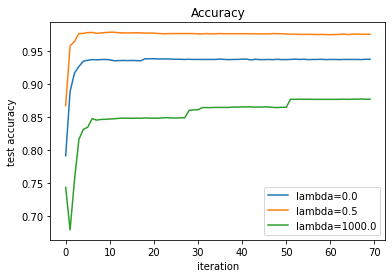

In [58]:
x  = [i for i in range(70)]
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure()

for treshold in [0.0, 0.5, 1000.0]:
    scores = [item['test'] for item in lambda_scores[treshold]]
    x = [i for i in range(len(scores))]
    plt.plot(x, scores, label='lambda=' + str(treshold))
plt.title('Accuracy')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
# f.savefig("experiments/data/MNIST/treshhhold_graph.pdf", bbox_inches='tight')
plt.close()

In [59]:
n_epochs = 500
n_epochs = 1000

batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


# The SimpleLinear which is for MNIST experiment
class SimpleLinear4(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28, h1)
        self.linear2 = torch.nn.Linear(h1, 4)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
    
# The SimpleLinear which is for MNIST experiment
class Simple4(torch.nn.Module):

    def __init__(self, h1=2048):
        super().__init__()
        self.linear1 = torch.nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)
    
transforms = torchvision.transforms.Compose([
                   torchvision.transforms.ToTensor(),
                 ])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)

dl = DataLoader(mnist_dataset)

X = dl.dataset.data # (60000,28, 28)
y = dl.dataset.targets #(60000)

# normalize to have 0 ~ 1 range in each pixel

X = X / 255.0

cluster_nums = [[0, 1], [2, 3]]

cluster_data0 = np.array([])
for cluster_num in cluster_nums[0]:
    cluster_data0 = np.concatenate((cluster_data0, np.where(y==cluster_num)[0]))
cluster_data0 = np.array(cluster_data0)
random.shuffle(cluster_data0)

cluster_data1 = []
for cluster_num in cluster_nums[1]:
    cluster_data1 = np.concatenate((cluster_data1, np.where(y==cluster_num)[0]))
cluster_data1 = np.array(cluster_data1)
random.shuffle(cluster_data1)
cluster_data = np.concatenate((cluster_data0, cluster_data1))
# cluster_data = cluster_data0
random.shuffle(cluster_data)

features = X[cluster_data]
labels = y[cluster_data]
print(np.unique(labels))

[0 1 2 3]


In [60]:
all_cnt = len(cluster_data)
train_data = []
test_data = []
for i in range(all_cnt):
    if i < all_cnt*0.8:
        train_data.append([features[i], labels[i]])
    else:
        test_data.append([features[i], labels[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size_train)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size_test)

In [65]:
import torch.optim as optim

network = SimpleLinear4(1)
# network = Simple4()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch, is_print=False):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and is_print:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            
def test(is_print=False):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    if is_print:
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
test()
for epoch in range(1, n_epochs + 1):
    if epoch % 100 == 0:
        train(epoch, True)
        test(True)
    else:
        test(False)
test(True)

Train Epoch: 100 [0/19804 (0%)]	Loss: 1.587467
Train Epoch: 100 [640/19804 (3%)]	Loss: 1.506430
Train Epoch: 100 [1280/19804 (6%)]	Loss: 1.515342
Train Epoch: 100 [1920/19804 (10%)]	Loss: 1.481595
Train Epoch: 100 [2560/19804 (13%)]	Loss: 1.542662
Train Epoch: 100 [3200/19804 (16%)]	Loss: 1.382589
Train Epoch: 100 [3840/19804 (19%)]	Loss: 1.384325
Train Epoch: 100 [4480/19804 (23%)]	Loss: 1.545728
Train Epoch: 100 [5120/19804 (26%)]	Loss: 1.480478
Train Epoch: 100 [5760/19804 (29%)]	Loss: 1.447626
Train Epoch: 100 [6400/19804 (32%)]	Loss: 1.348068
Train Epoch: 100 [7040/19804 (35%)]	Loss: 1.353897
Train Epoch: 100 [7680/19804 (39%)]	Loss: 1.390354
Train Epoch: 100 [8320/19804 (42%)]	Loss: 1.388970
Train Epoch: 100 [8960/19804 (45%)]	Loss: 1.317009
Train Epoch: 100 [9600/19804 (48%)]	Loss: 1.368041
Train Epoch: 100 [10240/19804 (52%)]	Loss: 1.290915
Train Epoch: 100 [10880/19804 (55%)]	Loss: 1.237003
Train Epoch: 100 [11520/19804 (58%)]	Loss: 1.311651
Train Epoch: 100 [12160/19804 (61%)

Train Epoch: 600 [0/19804 (0%)]	Loss: 0.942788
Train Epoch: 600 [640/19804 (3%)]	Loss: 0.939860
Train Epoch: 600 [1280/19804 (6%)]	Loss: 0.939582
Train Epoch: 600 [1920/19804 (10%)]	Loss: 0.917451
Train Epoch: 600 [2560/19804 (13%)]	Loss: 0.898435
Train Epoch: 600 [3200/19804 (16%)]	Loss: 0.856207
Train Epoch: 600 [3840/19804 (19%)]	Loss: 1.014909
Train Epoch: 600 [4480/19804 (23%)]	Loss: 0.927625
Train Epoch: 600 [5120/19804 (26%)]	Loss: 0.934998
Train Epoch: 600 [5760/19804 (29%)]	Loss: 0.953531
Train Epoch: 600 [6400/19804 (32%)]	Loss: 0.905319
Train Epoch: 600 [7040/19804 (35%)]	Loss: 0.927492
Train Epoch: 600 [7680/19804 (39%)]	Loss: 1.020430
Train Epoch: 600 [8320/19804 (42%)]	Loss: 1.112879
Train Epoch: 600 [8960/19804 (45%)]	Loss: 0.987788
Train Epoch: 600 [9600/19804 (48%)]	Loss: 0.988321
Train Epoch: 600 [10240/19804 (52%)]	Loss: 0.944639
Train Epoch: 600 [10880/19804 (55%)]	Loss: 0.996617
Train Epoch: 600 [11520/19804 (58%)]	Loss: 0.956783
Train Epoch: 600 [12160/19804 (61%)


Test set: Avg. loss: 0.8065, Accuracy: 3151/4950 (64%)


Test set: Avg. loss: 0.8065, Accuracy: 3151/4950 (64%)

